# Titanic: Accuracy beyond 80%
_Author: Jurjan Bootsma_

This Jupyter notebook makes a model for predicting which passengers survive the sinking Titanic. This is a competition from kaggle to get started with machine learning problems. This prediction has after submission an accuracy of over 80% (80.861%) and this ranks me at the moment of writing with the top 2.5% in the leaderboard.

In [1]:
#All the needed packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Reading Data

We start by loading the data from Kaggle.

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.head(100)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
98,99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Here we can see that there is an ID for every instance, that there is information whether the passenger survived or not and that there are 9 features we can use. Especially the age and cabin miss a lot of information.

# EDA & Feature Engineering

First a few functions so we can do the exploratory data analysis fast.

In [5]:
def EDA_bar(feature):
    survivors = train[train["Survived"]==1][feature].value_counts()
    dead = train[train["Survived"]==0][feature].value_counts()
    df = pd.DataFrame([survivors,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

In [6]:
def EDA_hist(feature):
    survivors = train[train["Survived"]==1][feature]
    dead = train[train["Survived"]==0][feature]
    plt.figure(figsize=(10,6))
    survivors.hist(histtype='step',label="Survived")
    dead.hist(histtype='step', label="Dead")
    plt.legend()
    plt.show()

In [7]:
def EDA_kde(feature):
    survivors = train[train["Survived"]==1][feature]
    dead = train[train["Survived"]==0][feature]
    plt.figure(figsize=(10,6))
    survivors.plot(kind='kde',label="Survivors")
    dead.plot(kind='kde', label="Dead")
    plt.legend()
    plt.grid()
    plt.show()    

## 1. Sex

We start by looking at how much influence the gender of the people on board has.

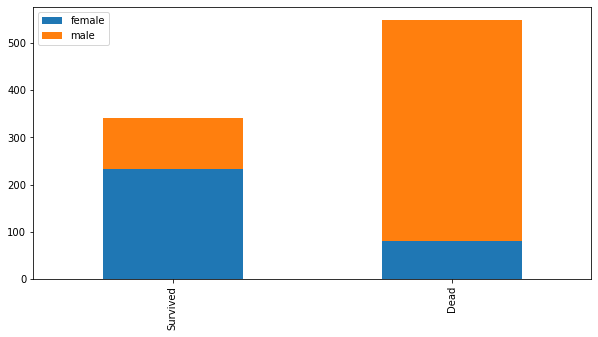

In [8]:
EDA_bar("Sex")

From this we see that female had a much bigger probability of surviving. This means this is useful information. However, we need to transform the categorical 'male' and 'female' to numbers 0 and 1, so that it can be used by all classifiers. We use mapping for this.

In [9]:
sex_map = {'male': 0, 'female': 1}
train['Sex']
train['Sex'] = train['Sex'].map(sex_map)
test['Sex'] = test['Sex'].map(sex_map)

# 2. Pclass

The next feature we are looking at is the Pclass, which means the class on board of the passenger.

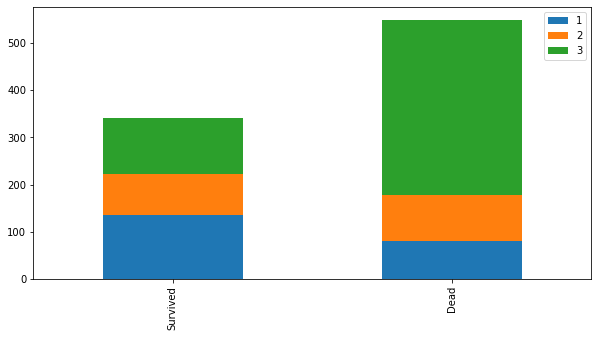

In [10]:
EDA_bar("Pclass")

Here we see that first class had a bigger probability of surviving that third class. We are going to use this like this, so we do not need to change anything.

# 3. Size of the Family

Here we are looking at the amount of siblings (SibSp) and parents/children (Parch). First we are looking at both of them apart.

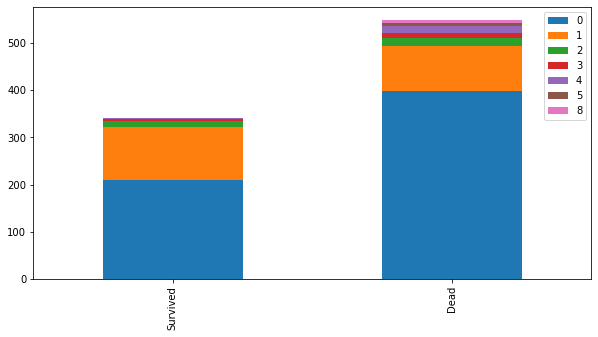

In [11]:
EDA_bar("SibSp")

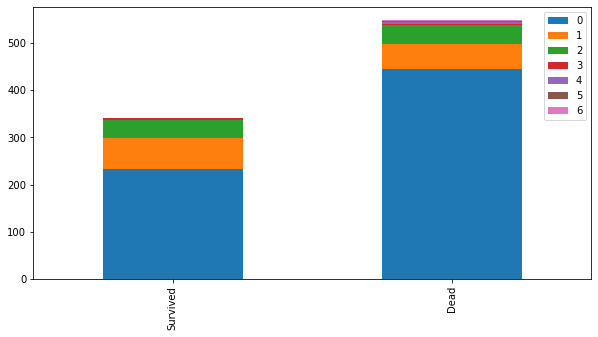

In [12]:
EDA_bar("Parch")

However, actually is the most information in the total size of the family. Now we will first construct a size of family and then a 'BigFamily' so that all family sizes from 4 are the same.  

In [13]:
train['FamilySize'] = train['SibSp']+train['Parch']
test['FamilySize'] = test['SibSp']+test['Parch']

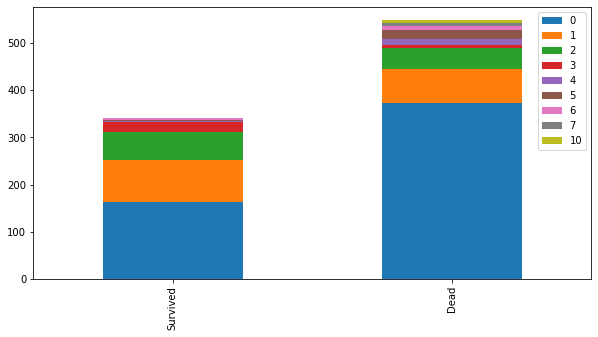

In [14]:
EDA_bar('FamilySize')

Here we can see that especially the big families had a bigger probability of drowning. We do not want our model to overfit on families of 10 for example. That is why we call families from the size of 5 'big families'. We again use mapping for this.

In [15]:
bigfamily_map = {0:0, 1:1, 2:2, 3:3, 4:4, 5:4, 6:4, 7:4, 10:4}

train['BigFamily'] = train['FamilySize'].map(bigfamily_map)
test['BigFamily'] = test['FamilySize'].map(bigfamily_map)

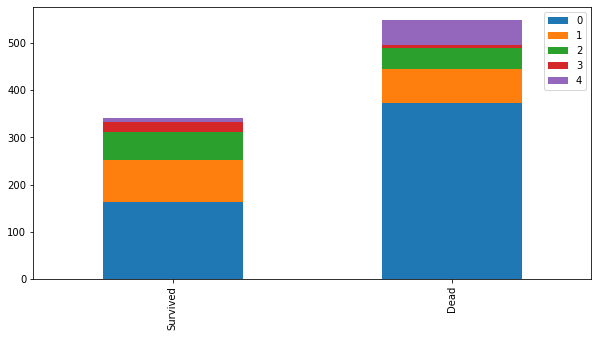

In [16]:
EDA_bar('BigFamily')

Now you can clearly see that especially families from 5 tend to die more.

# 4. Title

The next piece of information we are going to use is something from the feature name. We cannot use the name, since this is different for every person. That is why we only take the title of every person.

In [17]:
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [18]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Don           1
Mme           1
Ms            1
Name: Title, dtype: int64

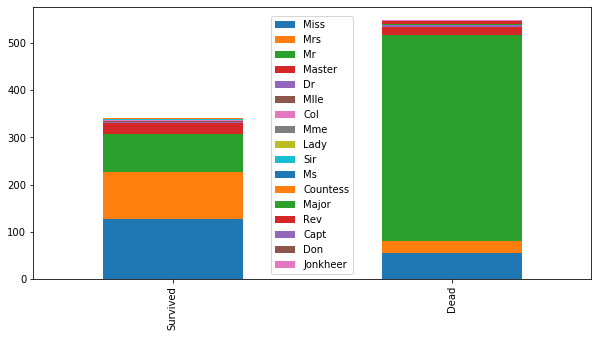

In [19]:
EDA_bar('Title')

Here you can see for instance that 'Mr' have a bad chance of surviving. Since there are so many titles, we only make the categories: 'Mr', 'Miss', 'Mrs' and 'Others'.

In [20]:
title_map = {"Mr": 0, "Miss": 1, "Mrs": 2, 
             "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
             "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }


In [21]:
train['Title'] = train['Title'].map(title_map)
test['Title'] = test['Title'].map(title_map)

# 5. Age

This is the first feature where we miss a lot of cases. You could replace all the NaNs with the median, but there is an even better way of handling this. There are some features which contain some information about what age a person can be. We are going to look at 'Pclass' and 'Title'.

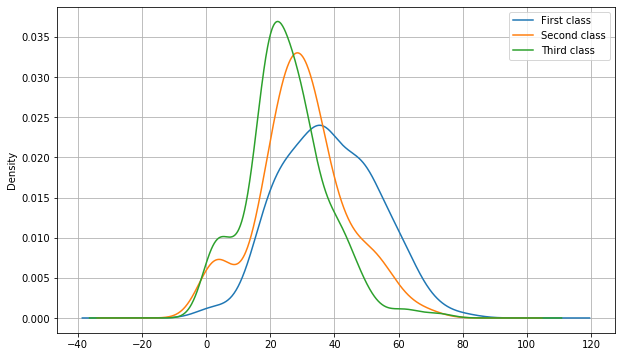

In [22]:
firstclass = train[train["Pclass"]==1]['Age']
secondclass = train[train["Pclass"]==2]['Age']
thirdclass = train[train["Pclass"]==3]['Age']
plt.figure(figsize=(10,6))
firstclass.plot(kind='kde',label="First class")
secondclass.plot(kind='kde', label="Second class")
thirdclass.plot(kind='kde', label="Third class")
plt.legend()
plt.grid()
plt.show()   

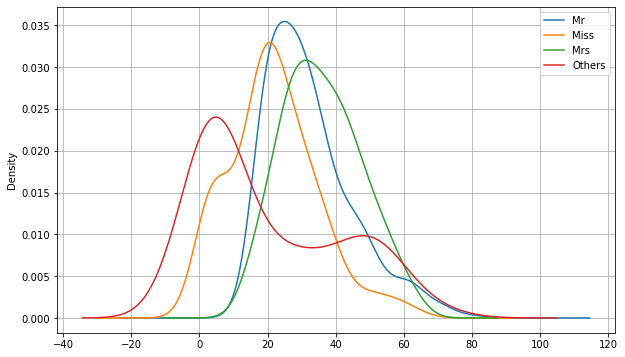

In [23]:
mr = train[train["Title"]==0]['Age']
miss = train[train["Title"]==1]['Age']
mrs = train[train["Title"]==2]['Age']
others = train[train['Title']==3]['Age']

plt.figure(figsize=(10,6))
mr.plot(kind='kde',label="Mr")
miss.plot(kind='kde', label="Miss")
mrs.plot(kind='kde', label="Mrs")
others.plot(kind='kde', label="Others")
plt.legend()
plt.grid()
plt.show()    

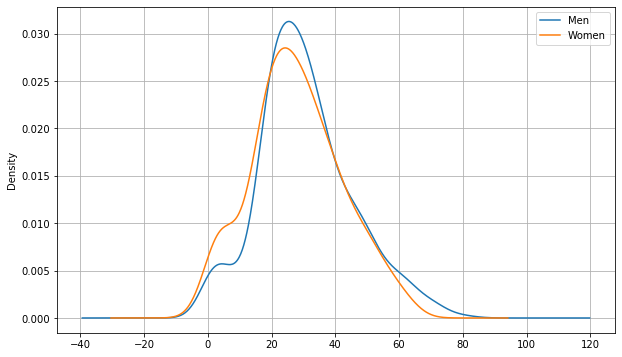

In [24]:
men = train[train["Sex"]==0]['Age']
women = train[train["Sex"]==1]['Age']

plt.figure(figsize=(10,6))
men.plot(kind='kde',label="Men")
women.plot(kind='kde',label="Women")
plt.legend()
plt.grid()
plt.show()

Here you can see that first class people are older than third class people. You can also see that 'others' are mostly spread, that 'Miss' are younger titles than 'Mrs'. We use this to add the missing age values. We are going to construct a new column for this. The last piece of information we can use is the 'sex'.

In [25]:
train["ClassTitle"] = 100*train["Sex"]+10*train["Pclass"]+train["Title"]
test["ClassTitle"] = 100*test["Sex"]+10*test["Pclass"]+test["Title"]

In [26]:
train["Age"].fillna(train.groupby("ClassTitle")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby("ClassTitle")["Age"].transform("median"), inplace=True)

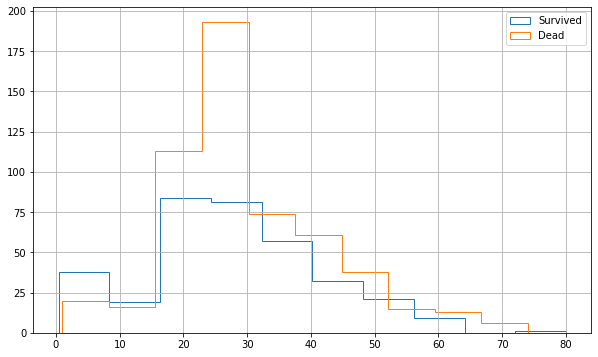

In [27]:
EDA_hist("Age")

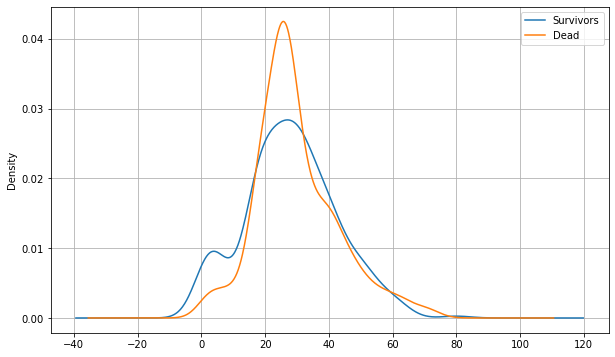

In [28]:
EDA_kde("Age")

We can see a few things from this. Firstly, young people tend to survive more. People between 21 and 25 seem to die more and from then it is almost even. That is why we are binning this into these 3 groups.

In [29]:
train.loc[train['Age'].between(0, 21, 'both'), 'AgeBin'] = 0 #Young people have high survive rate
train.loc[train['Age'].between(21, 25, 'right'), 'AgeBin'] = 1 #Others
train.loc[train['Age'].between(25, 100, 'right'), 'AgeBin'] = 2 #People around 30


test.loc[train['Age'].between(0, 21, 'both'), 'AgeBin'] = 1 #Young people have high survive rate
test.loc[train['Age'].between(21, 25, 'right'), 'AgeBin'] = 0 #Others
test.loc[train['Age'].between(25, 100, 'right'), 'AgeBin'] = 2 #People around 30

# 6. Embarked

This feature tells you where the passenger came aboard. You can see that there are correlations here. We will replace the few NaNs with the most common 'Embarked', namely S.

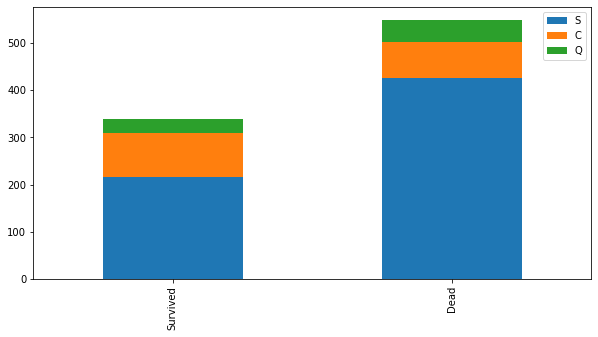

In [30]:
EDA_bar("Embarked")

In [31]:
train["Embarked"] = train["Embarked"].fillna("S")
test["Embarked"] = test["Embarked"].fillna("S")

We will use mapping to go from categorical to numerical.

In [32]:
embarked_map = {'S': 0, 'C': 1, 'Q': 2}

train['Embarked'] = train['Embarked'].map(embarked_map)
test['Embarked'] = test['Embarked'].map(embarked_map)

# 7. Cabin

Now we will be looking at the cabin. The numbers of the cabin do not say much, but the letter says something about the deck the passenger sleeps, so this could be important.

In [33]:
train['Cabin'] = train['Cabin'].str[:1]
test['Cabin'] = test['Cabin'].str[:1]

There are a lot of missing values in this feature, so we will name them 'M' (from Missing)

In [34]:
train["Cabin"]=train["Cabin"].fillna('M')
test["Cabin"]=test["Cabin"].fillna('M')

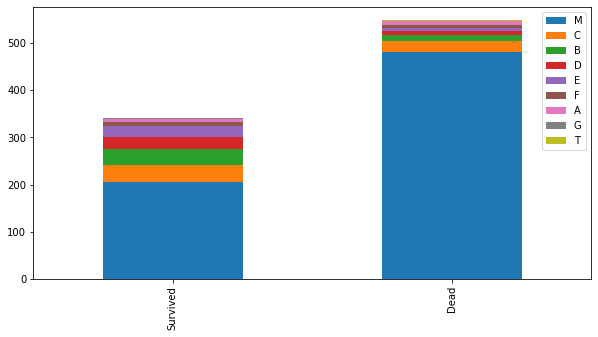

In [35]:
EDA_bar('Cabin')

We are now going to look how those cabins are correlated with the Pclass.

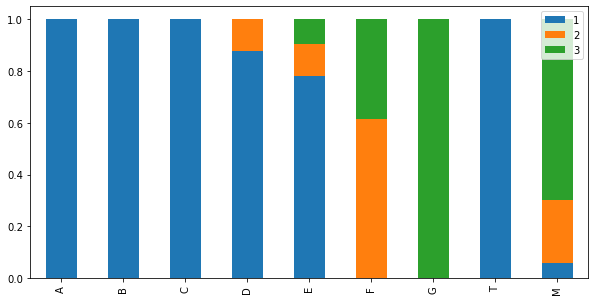

In [36]:
A = train[train["Cabin"]=="A"]["Pclass"].value_counts()
B = train[train["Cabin"]=="B"]["Pclass"].value_counts()
C = train[train["Cabin"]=="C"]["Pclass"].value_counts()
D = train[train["Cabin"]=="D"]["Pclass"].value_counts()
E = train[train["Cabin"]=="E"]["Pclass"].value_counts()
F = train[train["Cabin"]=="F"]["Pclass"].value_counts()
G = train[train["Cabin"]=="G"]["Pclass"].value_counts()
T = train[train["Cabin"]=="T"]["Pclass"].value_counts()
M = train[train["Cabin"]=="M"]["Pclass"].value_counts()

#Normalizing
A = A/sum(A)
B = B/sum(B)
C = C/sum(C)
D = D/sum(D)
E = E/sum(E)
F = F/sum(F)
G = G/sum(G)
T = T/sum(T)
M = M/sum(M)

df = pd.DataFrame([A,B,C,D,E,F,G,T,M])
df.index = ['A','B','C','D','E','F','G','T','M']
df.plot(kind='bar',stacked=True, figsize=(10,5))

We see that A,B,C and T are fully filled with Pclass 1. When we actually look in the internet you cannot find a deck T, so this probably belongs to somwhere between A,B,C (important later when we are going to group this). Next we are looking at how many people survived per deck.

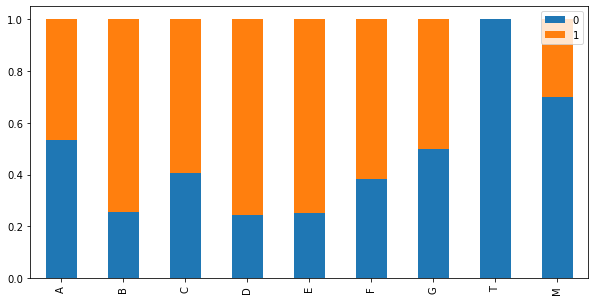

In [37]:
A = train[train["Cabin"]=="A"]["Survived"].value_counts()
B = train[train["Cabin"]=="B"]["Survived"].value_counts()
C = train[train["Cabin"]=="C"]["Survived"].value_counts()
D = train[train["Cabin"]=="D"]["Survived"].value_counts()
E = train[train["Cabin"]=="E"]["Survived"].value_counts()
F = train[train["Cabin"]=="F"]["Survived"].value_counts()
G = train[train["Cabin"]=="G"]["Survived"].value_counts()
T = train[train["Cabin"]=="T"]["Survived"].value_counts()
M = train[train["Cabin"]=="M"]["Survived"].value_counts()

#Normalizing
A = A/sum(A)
B = B/sum(B)
C = C/sum(C)
D = D/sum(D)
E = E/sum(E)
F = F/sum(F)
G = G/sum(G)
T = T/sum(T)
M = M/sum(M)

df = pd.DataFrame([A,B,C,D,E,F,G,T,M])
df.index = ['A','B','C','D','E','F','G','T','M']
df.plot(kind='bar',stacked=True, figsize=(10,5))

We choose now to put A,B,C,T together, D, E together, F,G together and M alone.

In [38]:
cabin_map = {"A": 0, "B": 0, "C": 0, "D": 1, "E": 1, "F": 2, "G": 2, "T": 0, "M": 3}
train['Cabin'] = train['Cabin'].map(cabin_map)
test['Cabin'] = test['Cabin'].map(cabin_map)

# 8. Fare

This feature means how much is paid to get aboard.

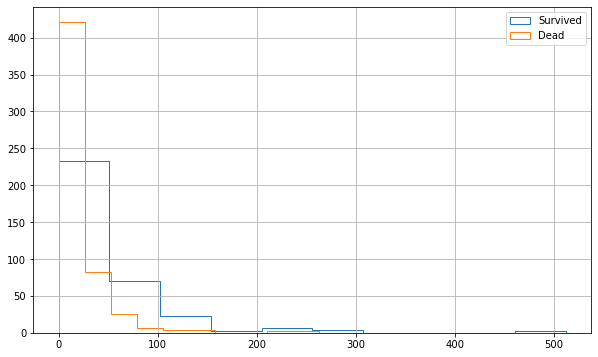

In [39]:
EDA_hist("Fare")

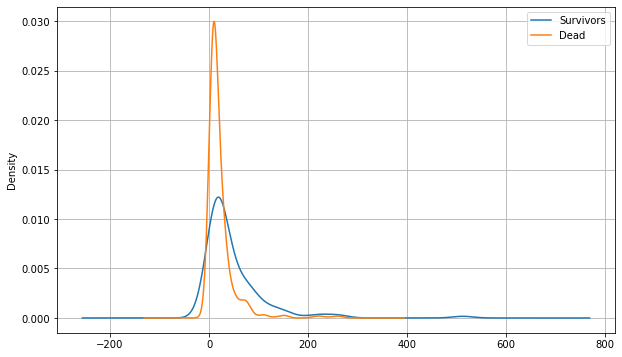

In [40]:
EDA_kde("Fare")

We can actually see only one big pattern. People who paid less than 27 dollars died more often than people who got more expensive tickets. Therefore we only select on that criterium.

In [41]:
train["Fare"] = (train["Fare"]<27) #1 for cheap tickets, 0 for expensive tickets
test["Fare"] = (test["Fare"]<27)

# 9. Ticket Frequency

There are people who paid for more than 1 ticket. We can find this by counting how many tickets there are in the 'Ticket' feature.

In [42]:
train['Ticket_Frequency'] = train.groupby('Ticket')['Ticket'].transform('count')
test['Ticket_Frequency'] = test.groupby('Ticket')['Ticket'].transform('count')

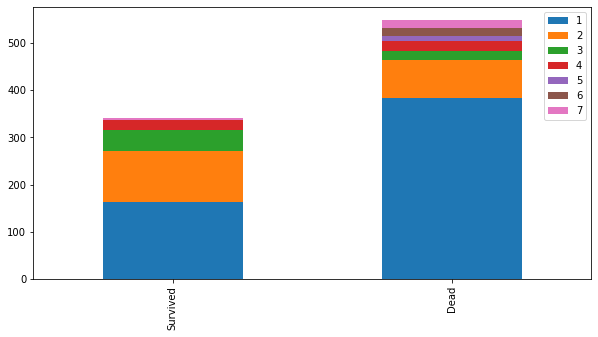

In [43]:
EDA_bar("Ticket_Frequency")

Here you can see that it has influence. We use mapping for this and we give tickets from the amount of 5 the same name.

In [44]:
fticket_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 4, 7: 4}
train['Ticket_Frequency'] = train['Ticket_Frequency'].map(fticket_map)
test['Ticket_Frequency'] = test['Ticket_Frequency'].map(fticket_map)

# 10. Survival Rate

This last feature is very important to let the accuracy get past the 80%. The survival rate is made of 2 components. First there is the family survival rate and then there is the ticket survival rate. We are now going to look at people who have the same surname or same ticket and look at how big the probability is with such as ticket or family to survive. Finally, we combine the 2 and that gives a survival rate which can be coupled to the test data.

In [45]:
train['Surname'] = train['Name'].str.extract('([A-Za-z]+)\,', expand=False)
test['Surname'] = test['Name'].str.extract('([A-Za-z]+)\,', expand=False)

In [46]:
family_survival_rate = train.groupby('Surname')['Survived','Surname','FamilySize'].median()

/Users/jurjanbootsma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In the next part we are first looking at surnames that are in the train and test data and if it has more family members than 1. If so, they have a big chance of being from the same family.

In [47]:
non_unique_families = [x for x in train['Surname'].unique() if x in test['Surname'].unique()]
family_rates = {}
for i in range(len(family_survival_rate)):
    # Does the surname occur in the train and test data and is the size of the family larger than 1?
    if family_survival_rate.index[i] in non_unique_families and family_survival_rate.iloc[i, 1] > 1:
        family_rates[family_survival_rate.index[i]] = family_survival_rate.iloc[i, 0]

Now we are looking at how big the probability is for the found families to survive and we save that in the data. People who we did not find in such a family get the mean survival rate.

In [48]:
#First for the training set.
family_survival_rate_train = []
mean_survival_rate = np.mean(train['Survived'])
for i in range(len(train)):
    if train['Surname'][i] in family_rates:
        family_survival_rate_train.append(family_rates[train['Surname'][i]])
    else:
        family_survival_rate_train.append(mean_survival_rate)
  
 #Now for the test set.
family_survival_rate_test = []
for i in range(len(test)):
    if test['Surname'][i] in family_rates:
        family_survival_rate_test.append(family_rates[test['Surname'][i]])
    else:
        family_survival_rate_test.append(mean_survival_rate)

In [49]:
#Now put that in our dataframe.
train['Family_survival_rate'] = family_survival_rate_train
test['Family_survival_rate'] = family_survival_rate_test

Now we want to extract the same kind of information from the data. We do this by looking if people have got the same ticket and we look at the ticket frequency.

In [50]:
ticket_survival_rate = train.groupby('Ticket')['Survived','Ticket','Ticket_Frequency'].median()

/Users/jurjanbootsma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


We apply the same kind of method as with the family.

In [51]:
non_unique_tickets = [x for x in train['Ticket'].unique() if x in test['Ticket'].unique()]
ticket_rates = {}
for i in range(len(ticket_survival_rate)):
    # Checing if a ticket exists in training and test set.
    if ticket_survival_rate.index[i] in non_unique_tickets and ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[ticket_survival_rate.index[i]] = ticket_survival_rate.iloc[i, 0]

Now we need to find how big the probability is of surviving for certain tickets.

In [52]:
ticket_survival_rate_train = []
mean_survival_rate = np.mean(train['Survived'])
for i in range(len(train)):
    if train['Ticket'][i] in ticket_rates:
        ticket_survival_rate_train.append(ticket_rates[train['Ticket'][i]])
    else:
        ticket_survival_rate_train.append(mean_survival_rate)
        
ticket_survival_rate_test = []
for i in range(len(test)):
    if test['Ticket'][i] in ticket_rates:
        ticket_survival_rate_test.append(ticket_rates[test['Ticket'][i]])
    else:
        ticket_survival_rate_test.append(mean_survival_rate)

Now put this in our train and test dataframe.

In [53]:
train['Ticket_survival_rate'] = ticket_survival_rate_train
test['Ticket_survival_rate'] = ticket_survival_rate_test

However, these new features seem to be the strongest when combined in 1 big survival rate, so we will do that next:

In [54]:
train['Survival_rate'] = (train['Ticket_survival_rate'] + train['Family_survival_rate']) / 2
test['Survival_rate'] = (test['Ticket_survival_rate'] + test['Family_survival_rate']) / 2

# Models

Now we will start looking at different models and we will see what model works the best. First we need to select the features that will give the best model, which seem to be the next ones: 

In [55]:
train = train[["Survived","Pclass","BigFamily","Title","Fare","Sex","AgeBin","Embarked","Survival_rate"]]

For testing we will use cross validation and split our data in the training set and the target.

In [56]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

X_train = train.drop("Survived", axis=1)
y_train = train["Survived"]

# 1. Worst model

The constructed model should always perform better than this.

In [57]:
#Just choose everyone is not a survivor
print("Worst model: ",sum(train["Survived"] == 0)/len(train["Survived"]))

Worst model:  0.6161616161616161


# 2. Decision Tree

In [58]:
clf = DecisionTreeClassifier()
acc = np.mean(cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring='accuracy'))
print("Accuracy: ",acc)

Accuracy:  0.8249063670411985


# 3. Random Forest

In [59]:
rfc = RandomForestClassifier()
#rfc = RandomForestClassifier(criterion='gini',n_estimators=1100,max_depth=5,min_samples_split=4,min_samples_leaf=5,max_features='auto',oob_score=True,random_state=42,n_jobs=-1,verbose=1)
                                    
                                    
acc = np.mean(cross_val_score(rfc, X_train, y_train, cv=k_fold, n_jobs=1, scoring='accuracy'))
print("Accuracy: ",acc)

Accuracy:  0.8305243445692885


# 4. kNN

In [60]:
clf = KNeighborsClassifier(n_neighbors = 13)
acc = np.mean(cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring='accuracy'))
print("Accuracy: ",acc)

Accuracy:  0.8058676654182273


# 5. Support Vector Machine

In [61]:
clf = SVC()
acc = np.mean(cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring='accuracy'))

print("Accuracy: ", acc)

Accuracy:  0.8327465667915106


Although support vector machine gives the highest accuracy, after some optimizing you will see that the random forest actually gives the best result.

# Optimzing

In [62]:
rfc = RandomForestClassifier(criterion='gini',n_estimators=1100,max_depth=5,min_samples_split=4,min_samples_leaf=5,max_features='auto',oob_score=True,random_state=42,n_jobs=-1,verbose=1)


acc = np.mean(cross_val_score(rfc, X_train, y_train, cv=k_fold, n_jobs=1, scoring='accuracy'))
print("Accuracy: ",acc)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks     

Accuracy:  0.8350187265917602


The next part shows the effect of our features.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.1s finished


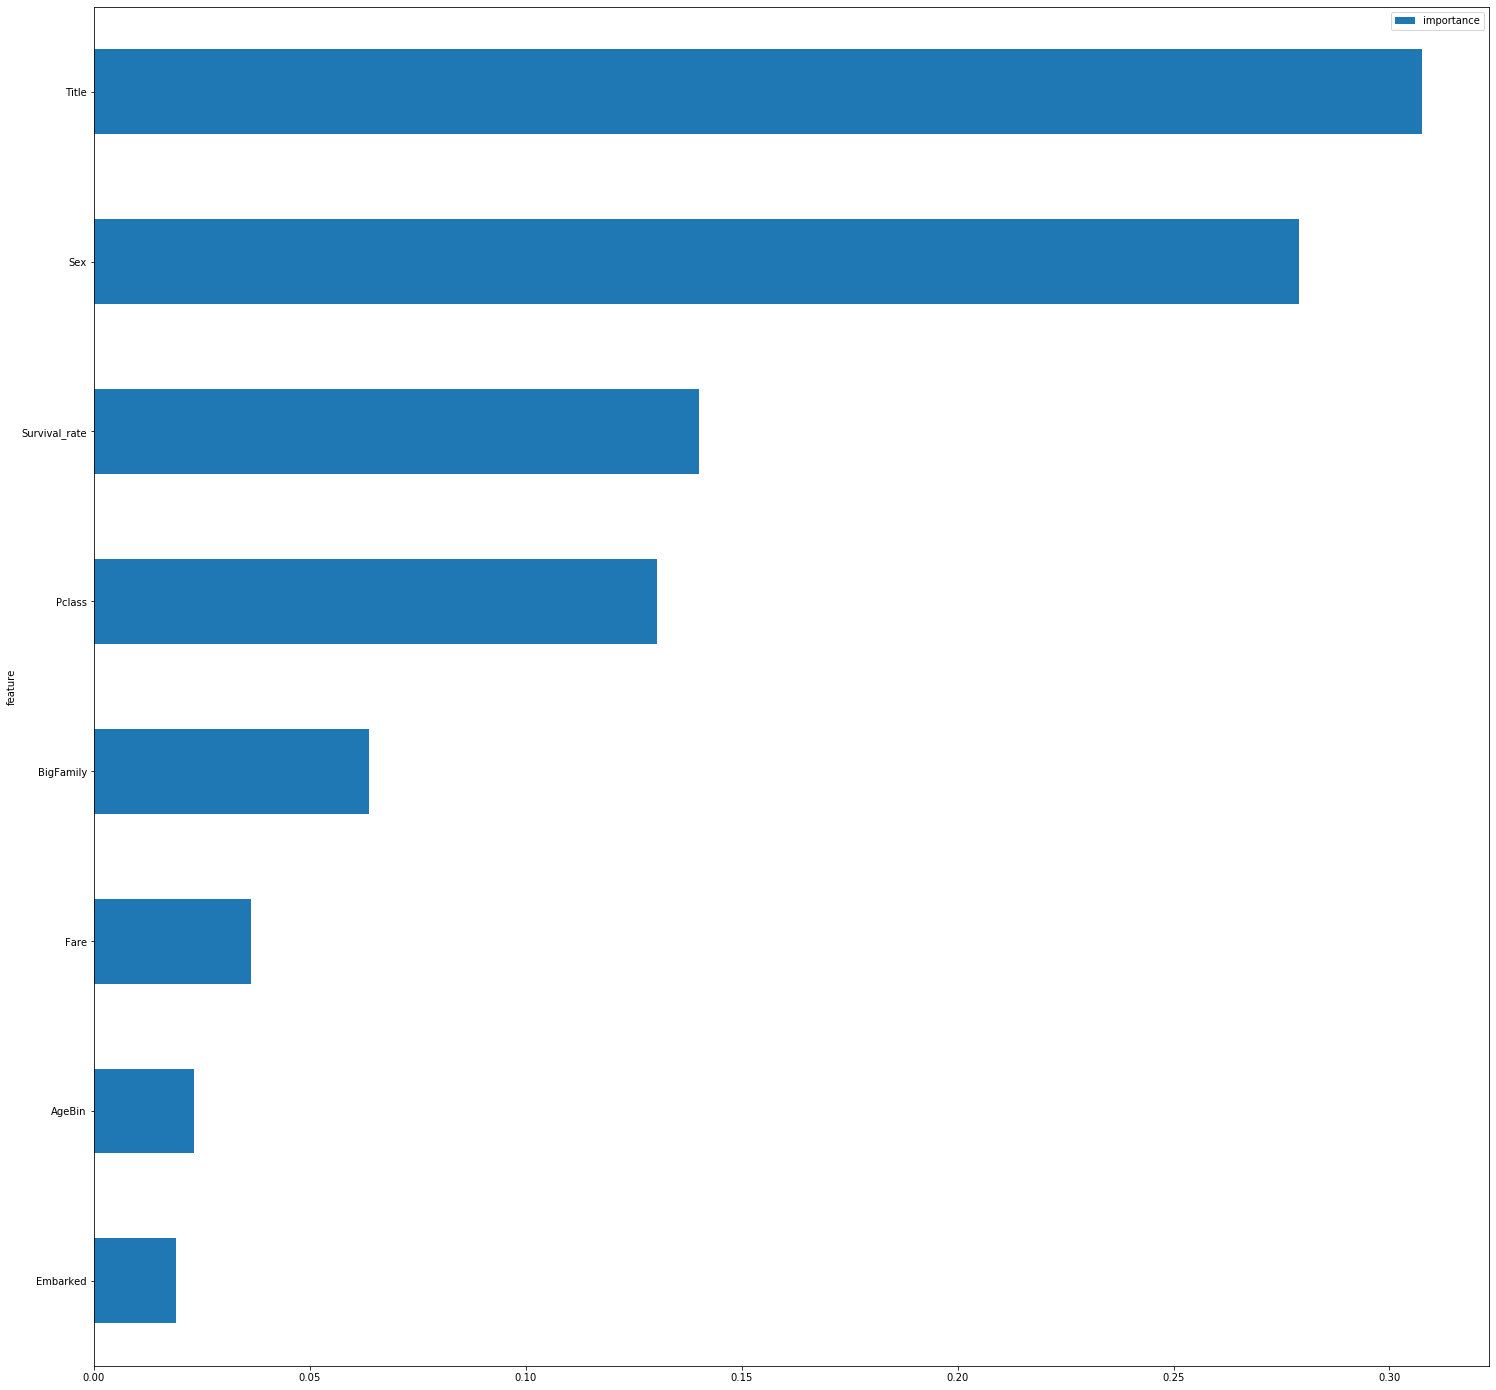

In [63]:
rfc = rfc.fit(X_train, y_train)

features = pd.DataFrame()
features['feature'] = train.columns[1:]
features['importance'] = rfc.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

# Predicting

Next we will fit our model and predict the outcome of all the passengers in the test set.

In [64]:
rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.1s finished


RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=1100, n_jobs=-1, oob_score=True,
                       random_state=42, verbose=1)

Now we need to select the same features for the test set (except for Survived)

In [65]:
test_data = test[["Pclass","BigFamily","Title","Fare","Sex","AgeBin","Embarked","Survival_rate"]].copy()

In [66]:
prediction = rfc.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.2s finished


In [67]:
#Making the submission ready for kaggle.
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": prediction
    })

submission.to_csv('submission.csv', index=False)